In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib

import itertools

In [3]:
tf.logging.set_verbosity(tf.logging.INFO)
sess = tf.InteractiveSession()

In [4]:
scaler_y = joblib.load('../models/scaler_y.sav')

In [5]:
train = pd.read_csv('../data/processed/train_numerical.csv')

In [6]:
df_test = pd.read_csv('../data/test.csv')
ID = df_test.Id

test = pd.read_csv('../data/processed/test_numerical.csv')

In [7]:
col_train = list(train.columns)
col_train_bis = list(train.columns)
col_train_bis.remove('SalePrice')

In [8]:
COLUMNS = col_train
FEATURES = col_train_bis
LABEL = "SalePrice"

In [9]:
# Train and Test 
training_set, validation_set = train_test_split(train, test_size=0.33, random_state=42)
training_set.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,LowQualFinSF,...,Fireplaces,GarageYrBlt,GarageCars,MiscVal,MoSold,YrSold,SalePrice,Outside_sqft,Inside_sqft,Basement_sqft
1013,0.235294,0.000000,0.036598,0.333333,0.857143,0.681159,0.833333,0.1575,0.249532,0.0,...,0.000000,0.978109,0.50,0.0,0.545455,0.50,0.239442,0.263052,0.404070,0.249532
333,0.000000,0.191693,0.033186,0.000000,0.285714,0.565217,0.000000,0.0000,0.224891,0.0,...,0.000000,0.970149,0.25,0.0,0.727273,0.75,0.081664,0.273092,0.125363,0.224891
433,0.588235,0.169329,0.012255,0.500000,0.428571,0.971014,0.950000,0.0450,0.392389,0.0,...,0.333333,0.998507,0.75,0.0,0.454545,0.25,0.238575,0.405622,0.268169,0.392389
677,0.058824,0.159744,0.021968,0.166667,0.714286,0.355072,0.000000,0.0000,0.192140,0.0,...,0.000000,0.955721,0.25,0.0,0.454545,0.00,0.093800,0.102912,0.081759,0.192140
1074,0.000000,0.364217,0.042333,0.500000,0.428571,0.855072,0.683333,0.0000,0.283843,0.0,...,0.333333,0.990050,0.50,0.0,0.363636,0.25,0.251406,0.483434,0.335029,0.283843


In [10]:
training_set.shape

(949, 28)

In [11]:
validation_set.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,LowQualFinSF,...,Fireplaces,GarageYrBlt,GarageCars,MiscVal,MoSold,YrSold,SalePrice,Outside_sqft,Inside_sqft,Basement_sqft
51,0.176471,0.166134,0.023090,0.333333,0.571429,0.449275,0.000000,0.00000,0.254523,0.681818,...,0.333333,0.987562,0.5,0.025806,0.727273,0.0,0.138013,0.321285,0.107558,0.254523
481,0.235294,0.335463,0.066737,0.333333,0.428571,0.971014,0.933333,0.00000,0.227074,0.000000,...,0.000000,0.998010,0.5,0.000000,0.363636,0.0,0.239069,0.215361,0.340116,0.227074
806,0.823529,0.076677,0.005815,0.500000,0.428571,0.963768,0.916667,0.00000,0.187149,0.151515,...,0.000000,0.997512,0.5,0.000000,0.545455,0.0,0.195056,0.324297,0.226381,0.187149
1260,0.941176,0.111821,0.011101,0.333333,0.428571,0.963768,0.933333,0.05125,0.170618,0.000000,...,0.000000,0.997512,0.5,0.000000,0.454545,0.0,0.182226,0.285643,0.200581,0.170618
297,0.000000,0.223642,0.039730,0.166667,0.714286,0.724638,0.366667,0.00000,0.278852,0.000000,...,0.000000,0.982587,0.5,0.000000,0.545455,0.0,0.199391,0.405622,0.135901,0.278852


In [12]:
validation_set.shape

(468, 28)

In [13]:
# Columns for tensorflow
feature_cols = [tf.contrib.layers.real_valued_column(k) for k in FEATURES]

## Training with a complex network

100, 50, 25, 12, 6 in respective hidden layers

In [14]:
tf.logging.set_verbosity(tf.logging.ERROR)
regressor = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols, 
                                          activation_fn = tf.nn.relu, hidden_units=[100, 50, 25, 12, 6])

In [15]:
training_set.reset_index(drop = True, inplace = True)

In [16]:
def input_fn(data_set, pred = False):
    if pred == False:
        feature_cols = {k: tf.constant(data_set[k].values) for k in FEATURES}
        labels = tf.constant(data_set[LABEL].values)
        return feature_cols, labels
    if pred == True:
        feature_cols = {k: tf.constant(data_set[k].values) for k in FEATURES}
        return feature_cols

In [17]:
regressor.fit(input_fn=lambda: input_fn(training_set), steps=500)

DNNRegressor(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._RegressionHead object at 0x1c3e2be048>, 'hidden_units': [100, 50, 25, 12, 6], 'feature_columns': (_RealValuedColumn(column_name='MSSubClass', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='LotFrontage', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='LotArea', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='OverallQual', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='OverallCond', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='YearBuilt', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='YearRemodAdd', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_

In [18]:
ev = regressor.evaluate(input_fn=lambda: input_fn(validation_set), steps=1)
loss_score1 = ev["loss"]
print("MSE loss on the validation set: {0:f}".format(loss_score1))

RMSE loss on the validation set: 0.002602


In [19]:
y = regressor.predict(input_fn=lambda: input_fn(validation_set))
predictions = list(itertools.islice(y, validation_set.shape[0]))
predictions = pd.DataFrame(scaler_y.inverse_transform(np.array(predictions).reshape(validation_set.shape[0],1)),
                           columns = ['Prediction'])

In [20]:
reality = pd.DataFrame(scaler_y.inverse_transform(np.array(validation_set.SalePrice).reshape(validation_set.shape[0],1)))

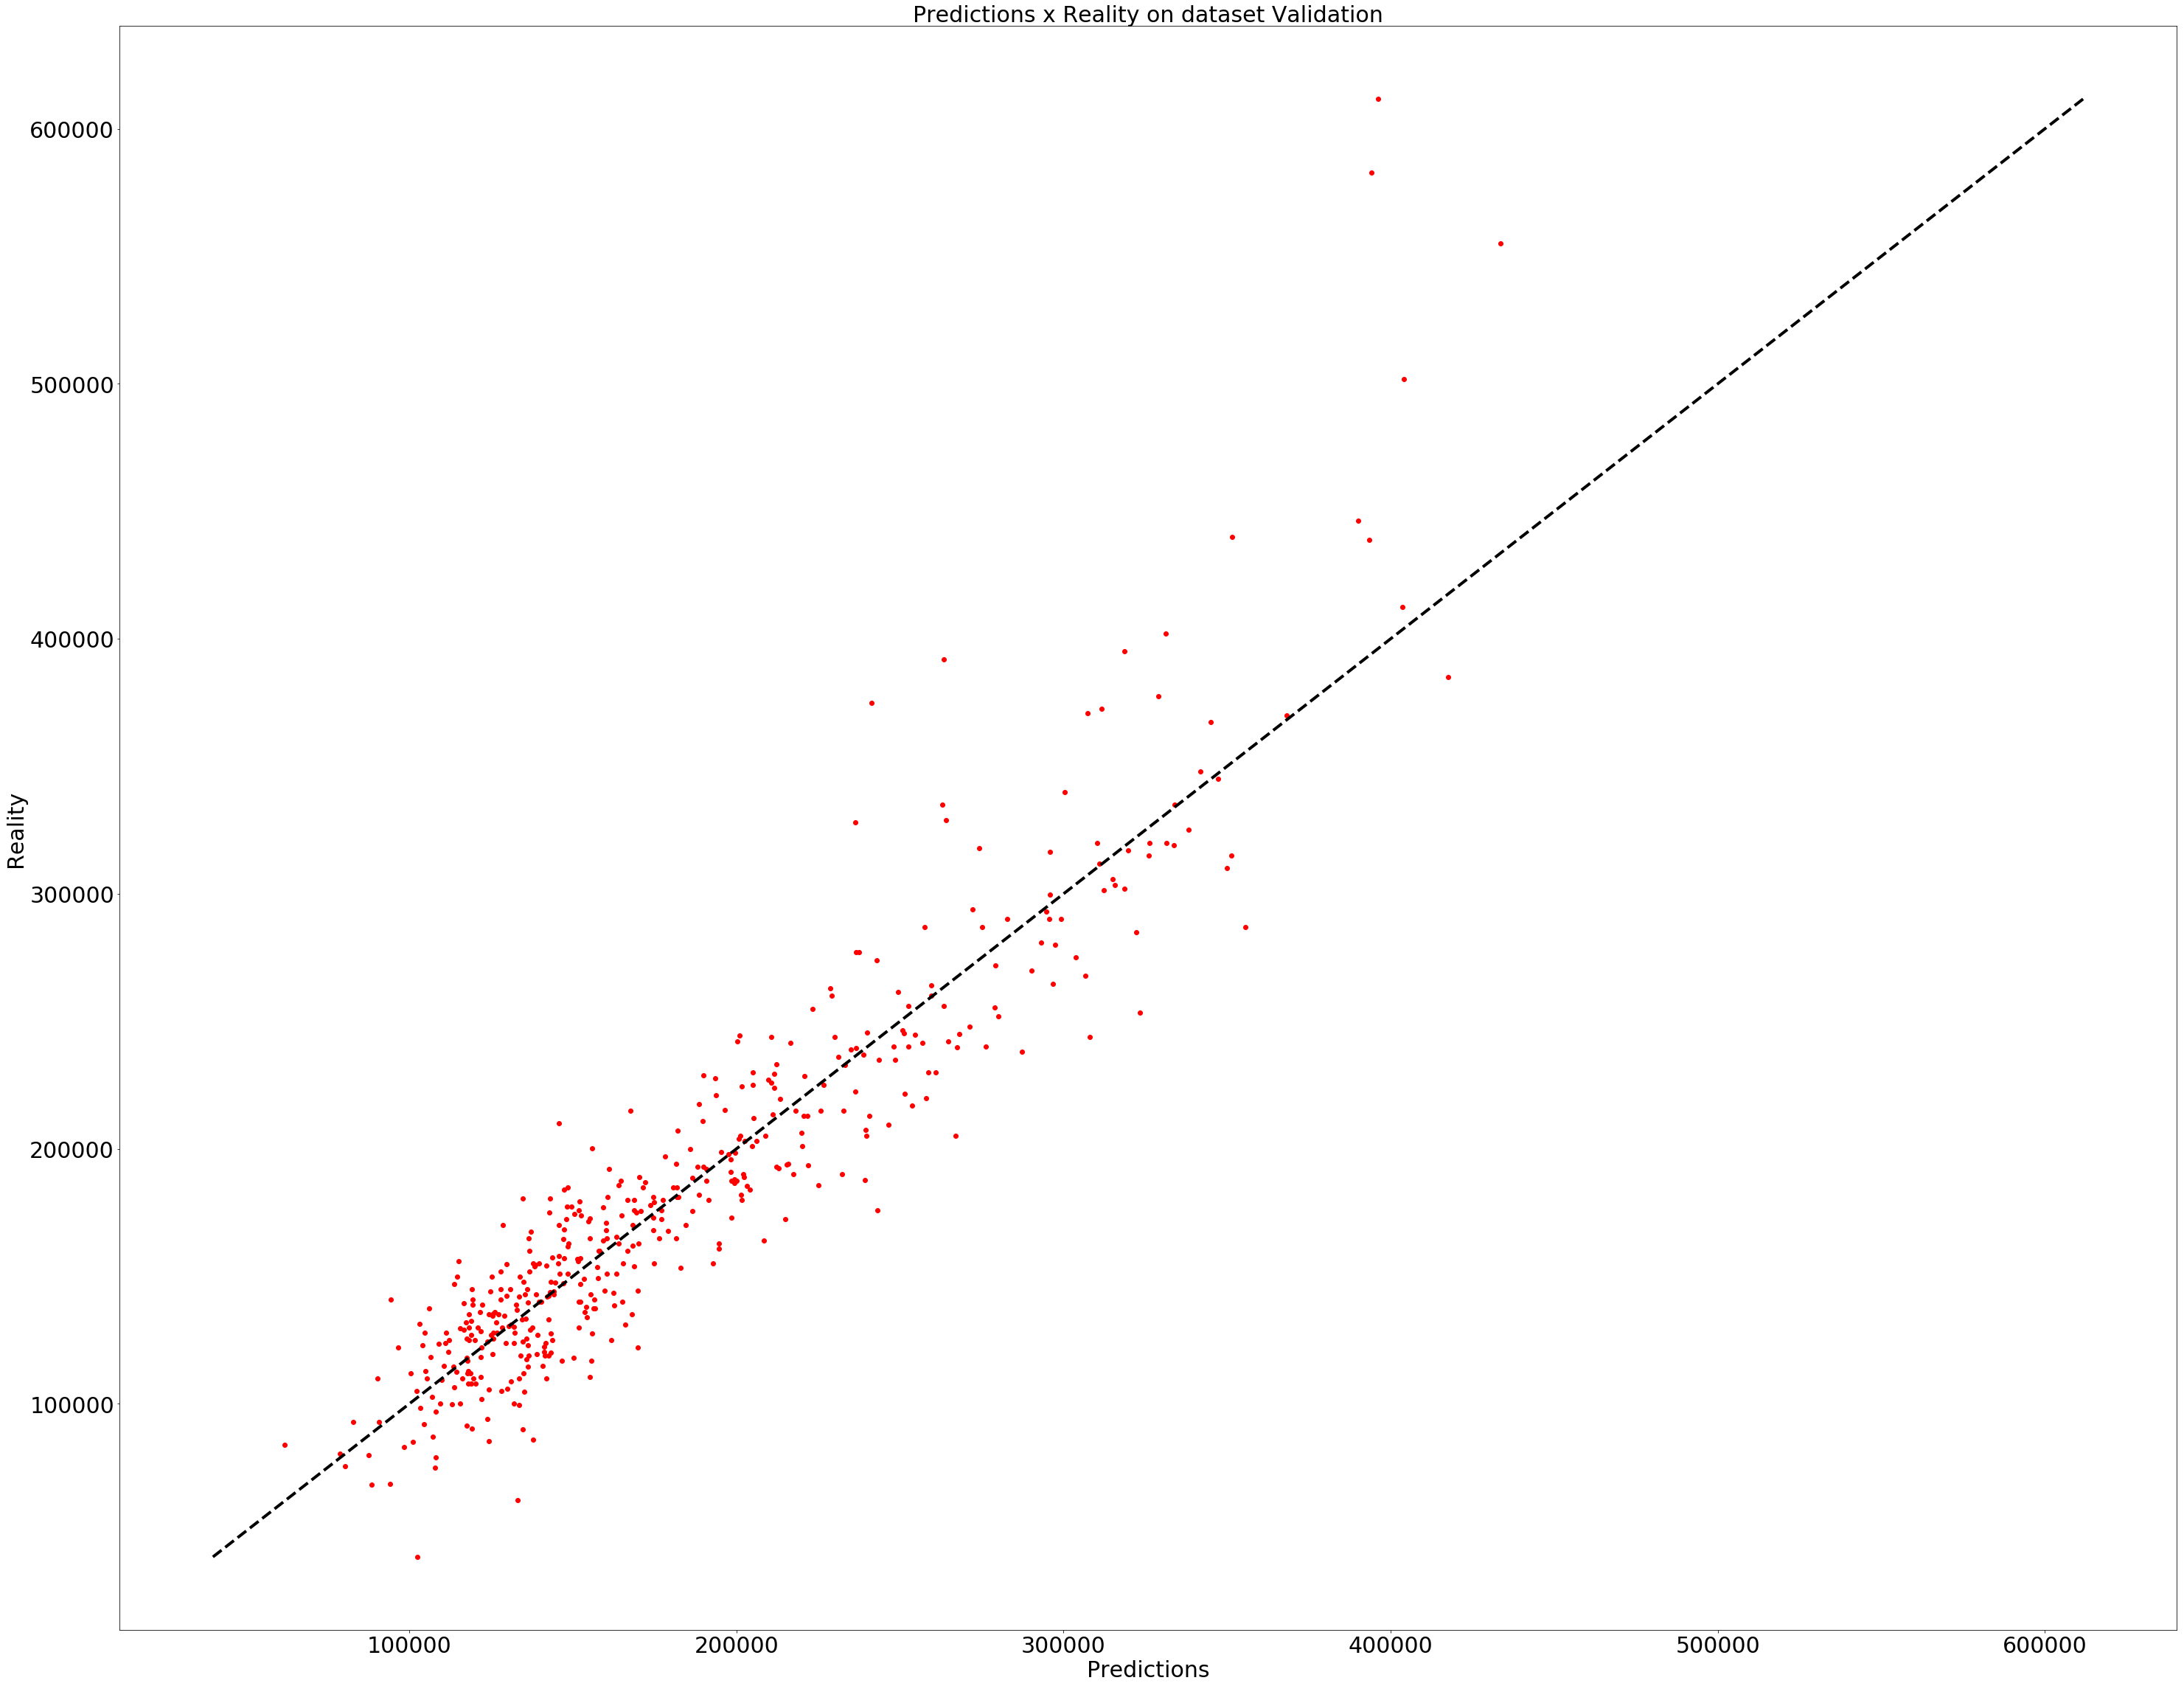

In [21]:
matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 

fig, ax = plt.subplots(figsize=(50, 40))

plt.style.use('ggplot')
plt.plot(predictions.values, reality.values, 'ro')
plt.xlabel('Predictions', fontsize = 30)
plt.ylabel('Reality', fontsize = 30)
plt.title('Predictions x Reality on dataset Validation', fontsize = 30)
ax.plot([reality.min(), reality.max()], [reality.min(), reality.max()], 'k--', lw=4)
plt.show()

Submit code on kaggle

In [22]:
y_predict = regressor.predict(input_fn=lambda: input_fn(test, pred = True))

In [23]:
y_predict = list(itertools.islice(y_predict, test.shape[0]))
y_predict = pd.DataFrame(scaler_y.inverse_transform(np.array(y_predict).reshape(len(y_predict),1)), columns = [LABEL])
y_predict = y_predict.join(ID)
y_predict.to_csv("kaggle/submission_continuous.csv",index=False)

## Training with medium sized networks

50, 25, 12, 6, 3

In [24]:
regressor_med = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols, 
                                          activation_fn = tf.nn.relu, hidden_units=[50, 25, 12, 6, 3])

In [25]:
regressor_med.fit(input_fn=lambda: input_fn(training_set), steps=500)

DNNRegressor(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._RegressionHead object at 0x1c3ec68470>, 'hidden_units': [50, 25, 12, 6, 3], 'feature_columns': (_RealValuedColumn(column_name='MSSubClass', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='LotFrontage', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='LotArea', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='OverallQual', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='OverallCond', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='YearBuilt', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='YearRemodAdd', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_na

In [26]:
ev_med = regressor_med.evaluate(input_fn=lambda: input_fn(validation_set), steps=1)
loss_score2 = ev_med["loss"]
print("MSE loss on the validation set: {0:f}".format(loss_score2))

RMSE loss on the validation set: 0.004036


## Training with a small sized networks

20, 10, 5

In [27]:
regressor_small = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols, 
                                          activation_fn = tf.nn.relu, hidden_units=[20, 10, 5])

In [28]:
regressor_small.fit(input_fn=lambda: input_fn(training_set), steps=500)

DNNRegressor(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._RegressionHead object at 0x1a3afb89e8>, 'hidden_units': [20, 10, 5], 'feature_columns': (_RealValuedColumn(column_name='MSSubClass', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='LotFrontage', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='LotArea', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='OverallQual', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='OverallCond', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='YearBuilt', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='YearRemodAdd', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='Mas

In [29]:
ev_small = regressor_small.evaluate(input_fn=lambda: input_fn(validation_set), steps=1)
loss_score3 = ev_small["loss"]
print("MSE loss on the validation set: {0:f}".format(loss_score3))

RMSE loss on the validation set: 0.003878


In [30]:
for h in [5, 12, 25, 50, 100, 200, 400]:
    regressor_loop = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols, 
                                          activation_fn = tf.nn.relu, hidden_units=[h])
    regressor_loop.fit(input_fn = lambda: input_fn(training_set) , steps=500)
    ev_loop = regressor_loop.evaluate(input_fn=lambda: input_fn(validation_set), steps=1)
    loss_score_loop = ev_loop["loss"]
    print("Neurons:",h,", Loss of validation set: {0:f}".format(loss_score_loop))

Neurons: 5 , Loss of validation set: 0.006328
Neurons: 12 , Loss of validation set: 0.003527
Neurons: 25 , Loss of validation set: 0.002801
Neurons: 50 , Loss of validation set: 0.003825
Neurons: 100 , Loss of validation set: 0.002742
Neurons: 200 , Loss of validation set: 0.002644
Neurons: 400 , Loss of validation set: 0.002593
